## KDE task

In [1]:
from sklearn.neighbors import KernelDensity
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import seed
from numpy.random import randn
import pandas as pd
from scipy.stats import normaltest
from mpl_toolkits.mplot3d import Axes3D
import itertools
from scipy.stats import multivariate_normal
from sklearn.model_selection import GridSearchCV

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['multivariate_normal']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
stocks = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv').loc[:,['Date','AAPL.Open',
                                                                                                                 'AAPL.High','AAPL.Low',
                                                                                                                 'AAPL.Close','AAPL.Volume']]
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks.set_index(stocks['Date'], inplace=True)
stocks

,Date,AAPL.Open,AAPL.High,AAPL.Low,AAPL.Close,AAPL.Volume
Date,,,,,,
2015-02-17,2015-02-17,127.489998,128.880005,126.919998,127.830002,63152400
2015-02-18,2015-02-18,127.629997,128.779999,127.449997,128.720001,44891700
2015-02-19,2015-02-19,128.479996,129.029999,128.330002,128.449997,37362400
2015-02-20,2015-02-20,128.619995,129.500000,128.050003,129.500000,48948400
2015-02-23,2015-02-23,130.020004,133.000000,129.660004,133.000000,70974100
...,...,...,...,...,...,...
2017-02-10,2017-02-10,132.460007,132.940002,132.050003,132.119995,20065500
2017-02-13,2017-02-13,133.080002,133.820007,132.750000,133.289993,23035400
2017-02-14,2017-02-14,133.470001,135.089996,133.250000,135.020004,32815500


In [3]:
assert not stocks.empty, "Stock data should not be empty"
assert 'Date' in stocks.index.names, "Date should be set as index"

In [4]:
stocks['pct_change'] = stocks['AAPL.Close'].pct_change() #calculating the daily returns
stocks.dropna(inplace=True)
stocks

,Date,AAPL.Open,AAPL.High,AAPL.Low,AAPL.Close,AAPL.Volume,pct_change
Date,,,,,,,
2015-02-18,2015-02-18,127.629997,128.779999,127.449997,128.720001,44891700,0.006962
2015-02-19,2015-02-19,128.479996,129.029999,128.330002,128.449997,37362400,-0.002098
2015-02-20,2015-02-20,128.619995,129.500000,128.050003,129.500000,48948400,0.008174
2015-02-23,2015-02-23,130.020004,133.000000,129.660004,133.000000,70974100,0.027027
2015-02-24,2015-02-24,132.940002,133.600006,131.169998,132.169998,69228100,-0.006241
...,...,...,...,...,...,...,...
2017-02-10,2017-02-10,132.460007,132.940002,132.050003,132.119995,20065500,-0.002266
2017-02-13,2017-02-13,133.080002,133.820007,132.750000,133.289993,23035400,0.008856
2017-02-14,2017-02-14,133.470001,135.089996,133.250000,135.020004,32815500,0.012979


In [5]:
assert 'pct_change' in stocks.columns, "pct_change column should be present after calculation"

In [6]:
stocks.index.min(), stocks.index.max()

(Timestamp('2015-02-18 00:00:00'), Timestamp('2017-02-16 00:00:00'))

In [7]:
train = stocks['2015':'2016']

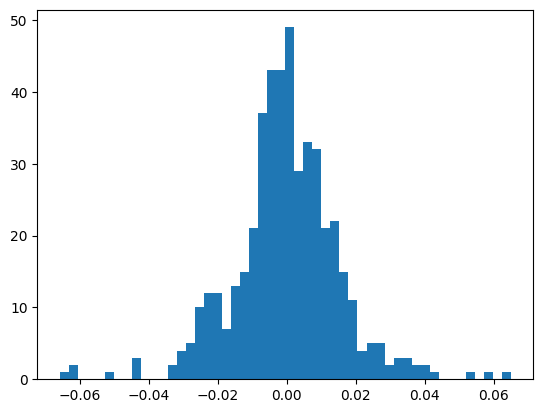

In [8]:
train_returns = train['pct_change']
plt.hist(train_returns, bins=50);

In [9]:
assert not train_returns.empty, "Training returns should not be empty"

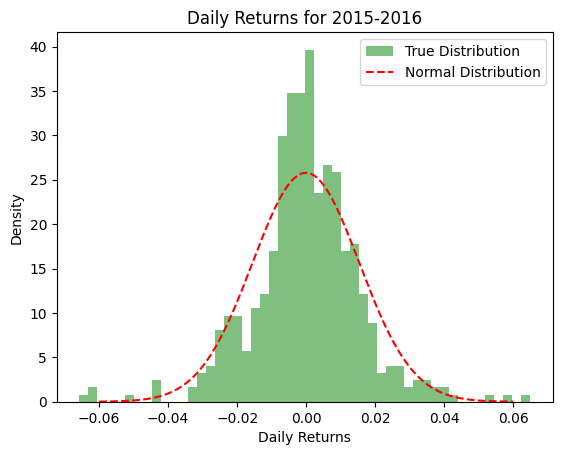

In [10]:
def normal_pdf(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

mu, sigma = train_returns.mean(), train_returns.std()
xs = np.linspace(-0.06, 0.06, 1000)

plt.hist(
    train_returns, bins=50, density=True, alpha=0.5, color='green', label='True Distribution'
)

plt.plot(
    xs, normal_pdf(xs, mu, sigma), color='red', linestyle='--', label='Normal Distribution'
)

plt.title('Daily Returns for 2015-2016')
plt.ylabel('Density')
plt.xlabel('Daily Returns')
plt.legend(loc='best')
None

In [11]:
assert mu != 0, "Mean should not be zero"
assert sigma != 0, "Standard deviation should not be zero"

The train data is not normal!

In [12]:
# Normality test function
def normality_test(x, alpha=0.05):
    # to-do: return the p-value of normality test
    stat, p_value = normaltest(x)
    print(f'p-value is equal to {p_value}, the data is {"not normal" if p_value < alpha else "normal"}')
    return p_value  # Return the p-value

# Perform normality test and store the result
p_value = normality_test(train_returns, alpha=0.01)  # Assign the returned value to p_value


p-value is equal to 1.965221057661904e-08, the data is not normal


In [13]:
assert p_value < 1, "p-value should be a valid probability"


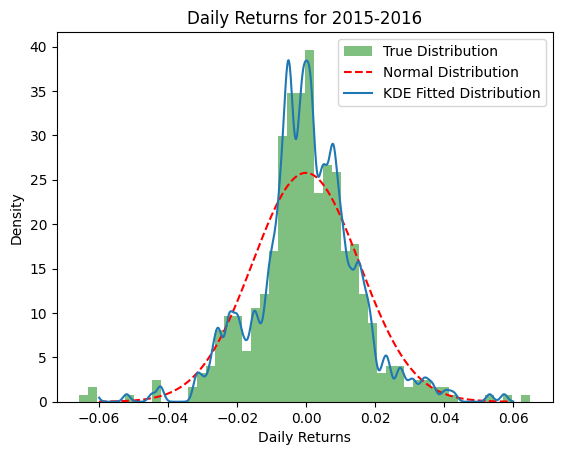

In [14]:
train_returns_arr = np.array(train_returns).reshape(-1, 1)
kde = KernelDensity(bandwidth=0.001).fit(train_returns_arr)


mu, sigma = train_returns.mean(), train_returns.std()

log_probs = kde.score_samples(xs.reshape(-1, 1))
kde_pdf = np.exp(log_probs)

plt.hist(train_returns, density=True, color='green', bins=50, alpha=0.5, histtype='stepfilled', label='True Distribution')
plt.plot(xs, normal_pdf(xs, mu, sigma), color='red', linestyle='--', label='Normal Distribution')
plt.plot(xs, kde_pdf, label='KDE Fitted Distribution')
plt.title('Daily Returns for 2015-2016')
plt.ylabel('Density')
plt.xlabel('Daily Returns')
plt.legend(loc='best')
None

In [15]:
assert kde is not None, "KDE model should be successfully fitted"
assert kde_pdf is not None, "KDE PDF should be calculated"

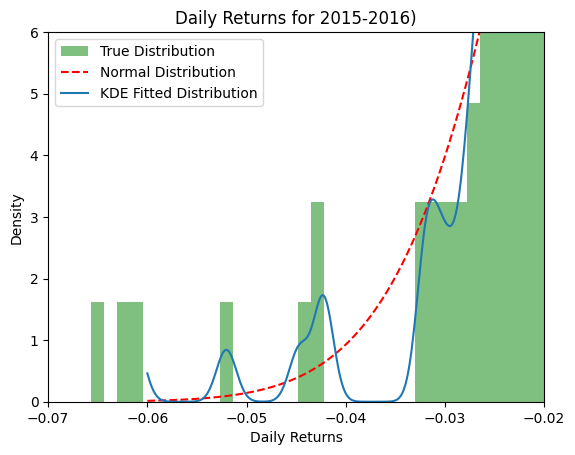

In [16]:
plt.hist(train_returns, density=True, color='green', bins=100, alpha=0.5, histtype='stepfilled', label='True Distribution')
plt.plot(xs, normal_pdf(xs, mu, sigma), color='red', linestyle='--', label='Normal Distribution')
plt.plot(xs, kde_pdf, label='KDE Fitted Distribution')
plt.title('Daily Returns for 2015-2016)')
plt.ylabel('Density')
plt.xlabel('Daily Returns')
plt.xlim([-0.07, -0.02])
plt.ylim([0, 6])
plt.legend(loc='upper left');

The fitted distribution is not precise. Let's optimize parameters!

In [20]:
params = {'bandwidth': np.linspace(0.0001, 0.01, 50)}  # to-do: define parameters for a grid search
grid = GridSearchCV(KernelDensity(), param_grid=params, cv=20, n_jobs=-1)
grid.fit(train_returns_arr)
best_bandwidth = grid.best_params_['bandwidth']
grid.fit(train_returns_arr)

print(grid.best_params_)

{'bandwidth': 0.004140816326530613}


In [21]:
assert best_bandwidth is not None, "Best bandwidth should be found"


In [22]:
best_kde = KernelDensity(bandwidth=grid.best_params_['bandwidth']).fit(train_returns_arr)  # to-do: train the best KDE model

log_probs = best_kde.score_samples(xs.reshape(-1,1))
best_kde_pdf = np.exp(log_probs)

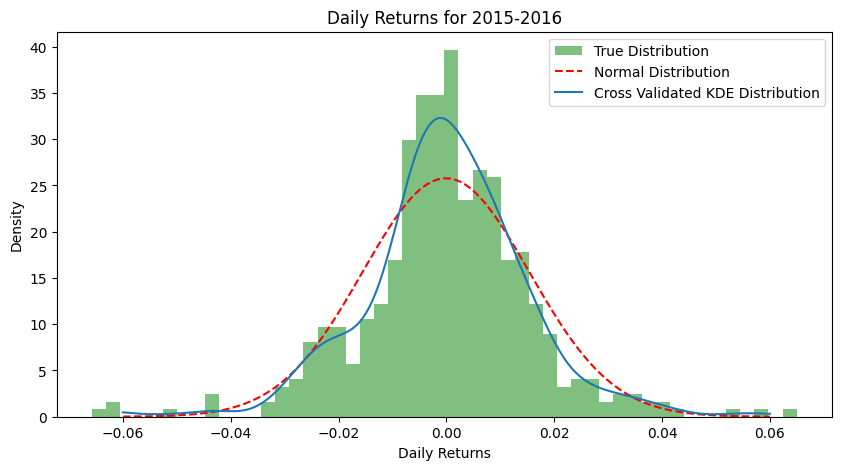

In [25]:
plt.subplots(figsize=(10,9))
plt.hist(train_returns, density=True, color='green',
         bins=50, alpha=0.5, histtype='stepfilled', label='True Distribution')
plt.plot(xs, normal_pdf(xs, mu, sigma), color='red',
         linestyle='--', label='Normal Distribution')
plt.plot(xs, best_kde_pdf, label='Cross Validated KDE Distribution')
plt.title('Daily Returns for 2015-2016')
plt.ylabel('Density')
plt.xlabel('Daily Returns')
plt.legend(loc='best');

In [ ]:
assert best_kde is not None, "Best KDE model should be successfully trained"
assert best_kde_pdf is not None, "Optimized KDE PDF should be calculated"

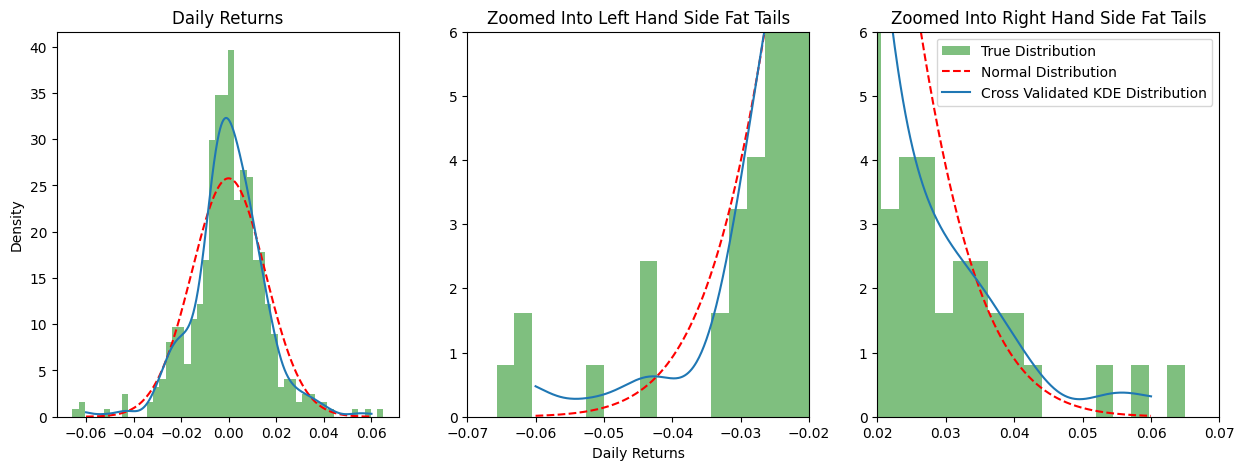

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i in range(3):
    ax[i].hist(train_returns, density=True, color='green', bins=50, alpha=0.5,
               histtype='stepfilled', label='True Distribution')
    ax[i].plot(xs, normal_pdf(xs, mu, sigma), color='red',
         linestyle='--', label='Normal Distribution')
    ax[i].plot(xs, best_kde_pdf, label='Cross Validated KDE Distribution')

ax[0].set_ylabel('Density')
ax[1].set_xlabel('Daily Returns')
ax[0].set_title('Daily Returns')
ax[1].set_title('Zoomed Into Left Hand Side Fat Tails')
ax[2].set_title('Zoomed Into Right Hand Side Fat Tails')

ax[1].set_xlim([-0.07, -0.02])
ax[1].set_ylim([0, 6])
ax[2].set_xlim([0.02, 0.07])
ax[2].set_ylim([0, 6])

ax[2].legend();

